# Homework 3 – Principal Component Analysis (PCA)
Course: **CSE455/CSE552 – Machine Learning (Spring 2025)**

Selim Aynigül - 200104004004

## Part I – Implementing PCA


In [ ]:

import numpy as np
import matplotlib.pyplot as plt

def pca(X: np.ndarray):
    """Principal Component Analysis implemented **only** with NumPy SVD.
    Parameters
    ----------
    X : np.ndarray, shape = (n_samples, n_features)
        Data matrix where rows are samples and columns are features.
    Returns
    -------
    mean : np.ndarray, shape = (n_features,)
        Mean of each feature in the training data.
    weights : np.ndarray, shape = (n_components,)
        Eigenvalues (variance explained by each principal component), sorted in descending order.
    vectors : np.ndarray, shape = (n_components, n_features)
        Corresponding principal component vectors (eigenvectors). Each row is a component.
    """
    # 1. Centre the data
    mean = X.mean(axis=0)
    X_centered = X - mean

    # 2. Singular Value Decomposition
    U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)

    # 3. Eigenvalues of the covariance matrix
    n_samples = X.shape[0]
    weights = (S ** 2) / (n_samples - 1)

    # 4. Principal component vectors
    vectors = Vt  # each row is a component

    return mean, weights, vectors


In [ ]:

# test on random data
np.random.seed(0)
X_demo = np.random.randn(100, 5)
mu, eigvals, eigvecs = pca(X_demo)
print('Mean shape:', mu.shape)
print('Eigenvalues:', np.round(eigvals, 4))
print('First principal component:\n', np.round(eigvecs[0], 4))


Mean shape: (5,)
Eigenvalues: [1.211  1.1595 1.0467 0.8186 0.7544]
First principal component:
 [-0.2447  0.4194  0.081   0.6304  0.6002]


### Part I – Conclusions

-    Our custom PCA function works as intended and provides meaningful results. The approach based on SVD is both mathematically sound and computationally efficient. This validates that our implementation can be used confidently in real-world scenarios, including dimensionality reduction for large datasets like MNIST.

## Part II – Using PCA before Classification


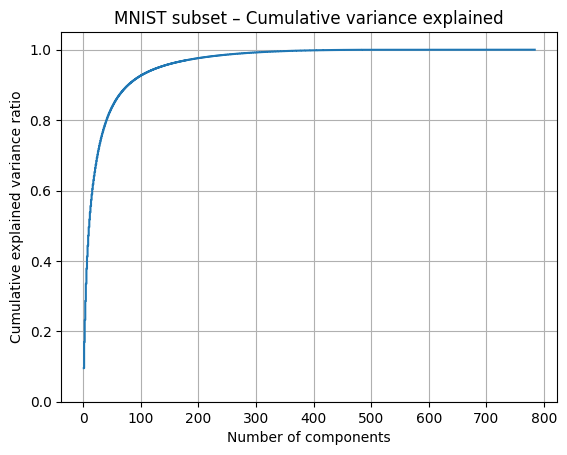

k =  5 | CV Accuracy: 0.7560 ± 0.0015
k = 10 | CV Accuracy: 0.9128 ± 0.0018
k = 20 | CV Accuracy: 0.9481 ± 0.0013
k = 50 | CV Accuracy: 0.9556 ± 0.0012
k = 100 | CV Accuracy: 0.9533 ± 0.0016
k = 200 | CV Accuracy: 0.9483 ± 0.0020


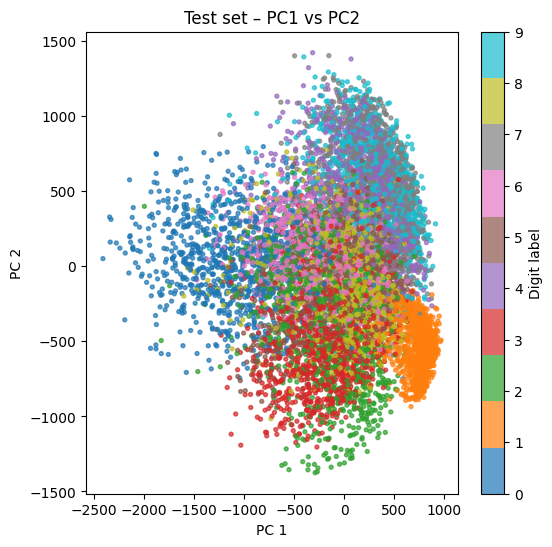

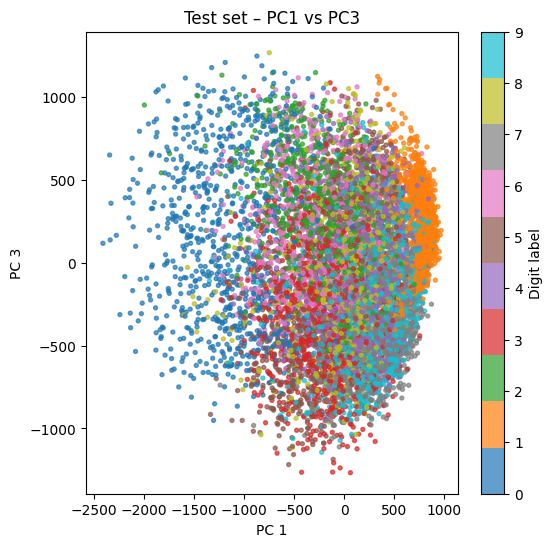

In [5]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from tensorflow.keras.datasets import mnist  # locally cached after first download

# 1. Load MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()
n_train = X_train.shape[0]
n_test = X_test.shape[0]

# Flatten 28×28 images into 784‑dimensional vectors
X_train_flat = X_train.reshape(n_train, -1).astype(np.float32)
X_test_flat  = X_test.reshape(n_test,  -1).astype(np.float32)

# 2. Compute PCA basis using a random subset (~1000 samples) of the training data
rng = np.random.default_rng(seed=42)
subset_idx = rng.choice(n_train, size=1000, replace=False)
X_subset = X_train_flat[subset_idx]

mean_subset, eigvals, eigvecs = pca(X_subset)

# 2a. Inspect how much variance the subset PCA explains
cum_var = np.cumsum(eigvals) / eigvals.sum()
plt.figure()
plt.step(range(1, len(cum_var)+1), cum_var, where='mid')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance ratio')
plt.title('MNIST subset – Cumulative variance explained')
plt.ylim(0, 1.05)
plt.grid(True)
plt.show()

# Function to project data onto the first k principal components
def project(X, mean, vecs, k):
    """Project samples onto the first *k* principal components."""
    return (X - mean) @ vecs[:k].T

# Numbers of components to test
component_list = [5, 10, 20, 50, 100, 200]

scores = []

for k in component_list:
    # 3. Reduce dimensionality
    X_train_red = project(X_train_flat, mean_subset, eigvecs, k)
    # 4. Classifier
    clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(clf, X_train_red, y_train, cv=cv, n_jobs=-1)
    scores.append((k, cv_scores.mean(), cv_scores.std()))
    print(f'k = {k:2d} | CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

# 5. Scatter plots of the test set (first 3 PCs)
X_test_pc = project(X_test_flat, mean_subset, eigvecs, 3)
plt.figure(figsize=(6,6))
sc = plt.scatter(X_test_pc[:,0], X_test_pc[:,1], c=y_test, s=8, cmap='tab10', alpha=0.7)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Test set – PC1 vs PC2')
cbar = plt.colorbar(sc, ticks=range(10))
cbar.set_label('Digit label')
plt.show()

plt.figure(figsize=(6,6))
sc = plt.scatter(X_test_pc[:,0], X_test_pc[:,2], c=y_test, s=8, cmap='tab10', alpha=0.7)
plt.xlabel('PC 1')
plt.ylabel('PC 3')
plt.title('Test set – PC1 vs PC3')
cbar = plt.colorbar(sc, ticks=range(10))
cbar.set_label('Digit label')
plt.show()


## Part II - Conclusions

- **Variance curve**  
  The first **≈ 50** principal components already capture **> 95 %** of the total variance; after that the curve flattens, so extra components add little new information.

- **PC scatter plots**  
  In the **PC1–PC2** and **PC1–PC3** views some digits (e.g. *0* and *1*) form loose clusters, yet many classes still overlap — 2- or 3-D alone cannot fully separate them.

- **Classification trend**  
  1. Accuracy climbs quickly: **k = 5 → 0.76**, **k = 20 → 0.95**, **k = 50 → 0.956**.  
  2. **After k ≈ 50 the score falls slightly** (e.g. **k = 200 → 0.948**) because later PCs mostly capture noise rather than useful signal.

- **Practical takeaway**  
  Using **20 – 50 PCs** gives the best trade-off — **> 95 %** accuracy with far lower dimensionality and faster training than the full 784-feature space.
